# Entrega 2

## Evaluacion de modelos

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


El siguiente paso en nuestro trabajo para predecir la edad de los abulones fue plantear diferentes tipos de modelos de regresión. Primero, desarrollamos un modelo de referencia (benchmark) utilizando solo dos features con el mismo target rings, para evaluar su rendimiento. Posteriormente, se elaboraron otros modelos con una mayor cantidad de features con el fin de compararlos y determinar cuál ofrece el mejor desempeño.

### Analisis introductorio

In [8]:
df = pd.read_csv("C:/Users/MABEL/Desktop/EntregaIAA/abalone.csv")
df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


El conjunto de datos fue preparado específicamente para trabajar con redes neuronales, por lo que será necesario transformar los valores a su escala original. Esto se logra dividiendo cada elemento continuo del conjunto por 200, según las indicaciones del dataset. Sin embargo, este proceso podría generar algunos problemas, como una posible disminución en el valor de R² del modelo, debido a posibles problemas de procesamiento.

In [9]:
columns_to_rescale = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

df[columns_to_rescale] = df[columns_to_rescale] * 200
df.head(5)
df.shape

(4177, 9)

Luego de ajustar los valores a la escala correcta, evaluamos el target en función de cada feature continuo. Este análisis nos permitió identificar posibles tendencias o detectar valores atípicos en los datos.

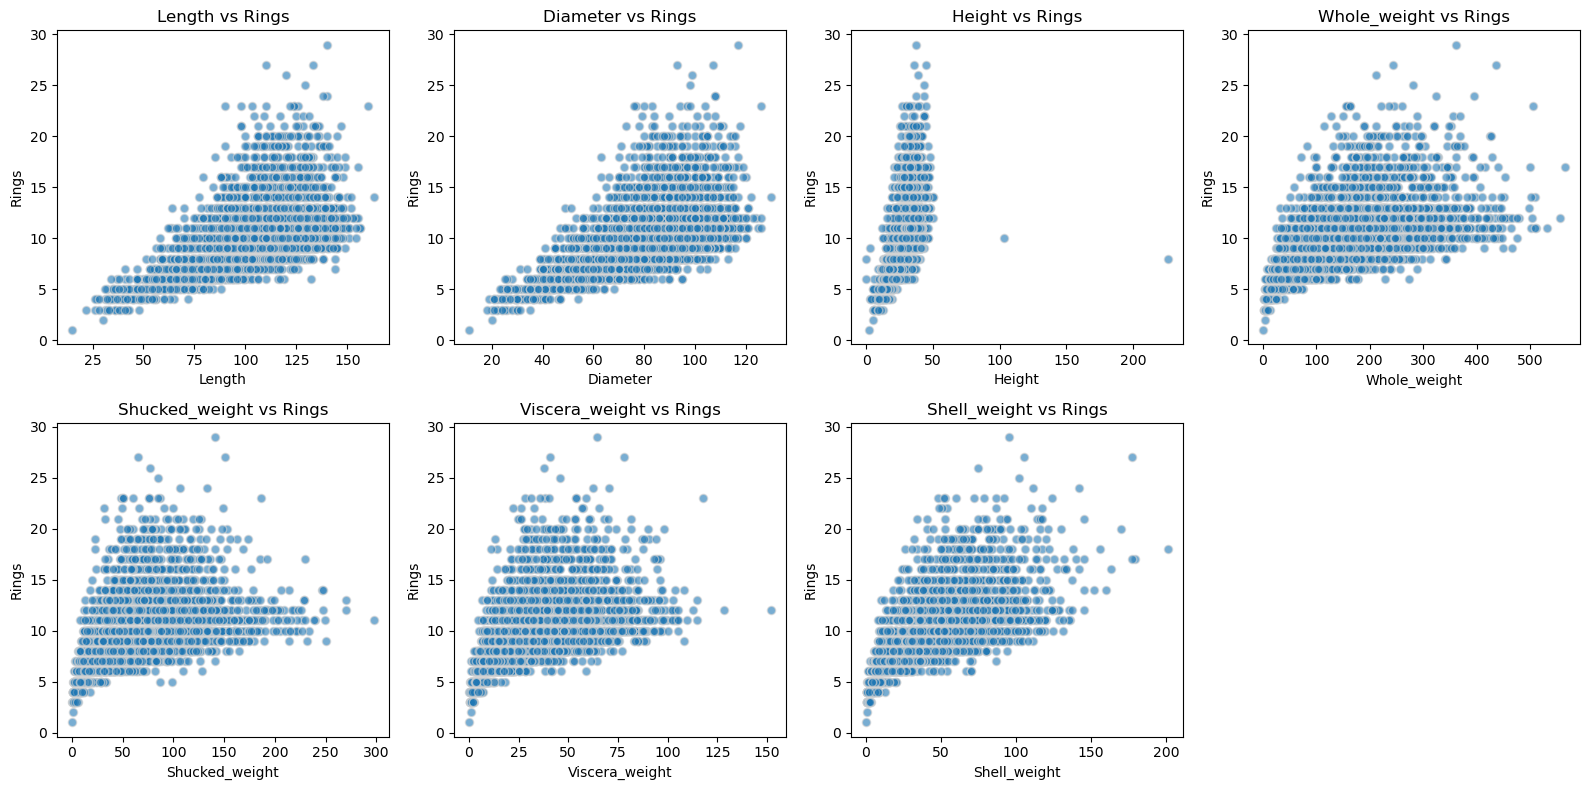

In [10]:
features= df.drop(columns=['Sex', 'Rings'], axis=0) #Nos quedamos solamente con los features continuos
target = df['Rings']

fig, axs = plt.subplots(2,4, figsize=(16, 8))
axs = axs.flatten()

for i, feature in enumerate(features.columns):
    axs[i].scatter(features[feature], target, alpha = 0.6, edgecolor= 'lightgray')
    axs[i].set_title(f'{feature} vs Rings')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Rings')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
# plt.show() 

Los siguientes gráficos nos permiten observar el comportamiento del target en función de los features. Se pueden identificar valores atípicos en varias características, siendo más notorias en Height, Shucked_weight y Visera_weight. Para mejorar el rendimiento del modelo, decidimos ajustar algunos de estos features, limitando sus rangos.

Primero observemos la cantidad de valores antes de su acotacion.

In [11]:
df.count()

Sex               4177
Length            4177
Diameter          4177
Height            4177
Whole_weight      4177
Shucked_weight    4177
Viscera_weight    4177
Shell_weight      4177
Rings             4177
dtype: int64

In [16]:
df = df[(df['Rings'] < 15.5) & (df['Height'] < 70) & (df['Shucked_weight'] < 250) & (df['Viscera_weight'] < 120) & (df['Shell_weight'] < 150)]

df.count()

Sex               3907
Length            3907
Diameter          3907
Height            3907
Whole_weight      3907
Shucked_weight    3907
Viscera_weight    3907
Shell_weight      3907
Rings             3907
dtype: int64

La diferencia en la proporción entre la cantidad inicial de atributos (4177) y la cantidad final (3907) es aproximadamente un 6.48% del conjunto de datos, lo que indica que se eliminó esa cantidad del dataset durante el proceso de filtrado.

Para visualizarlo mejor se procedio a realizar un grafico del target *rings* evaluado en los features continuos

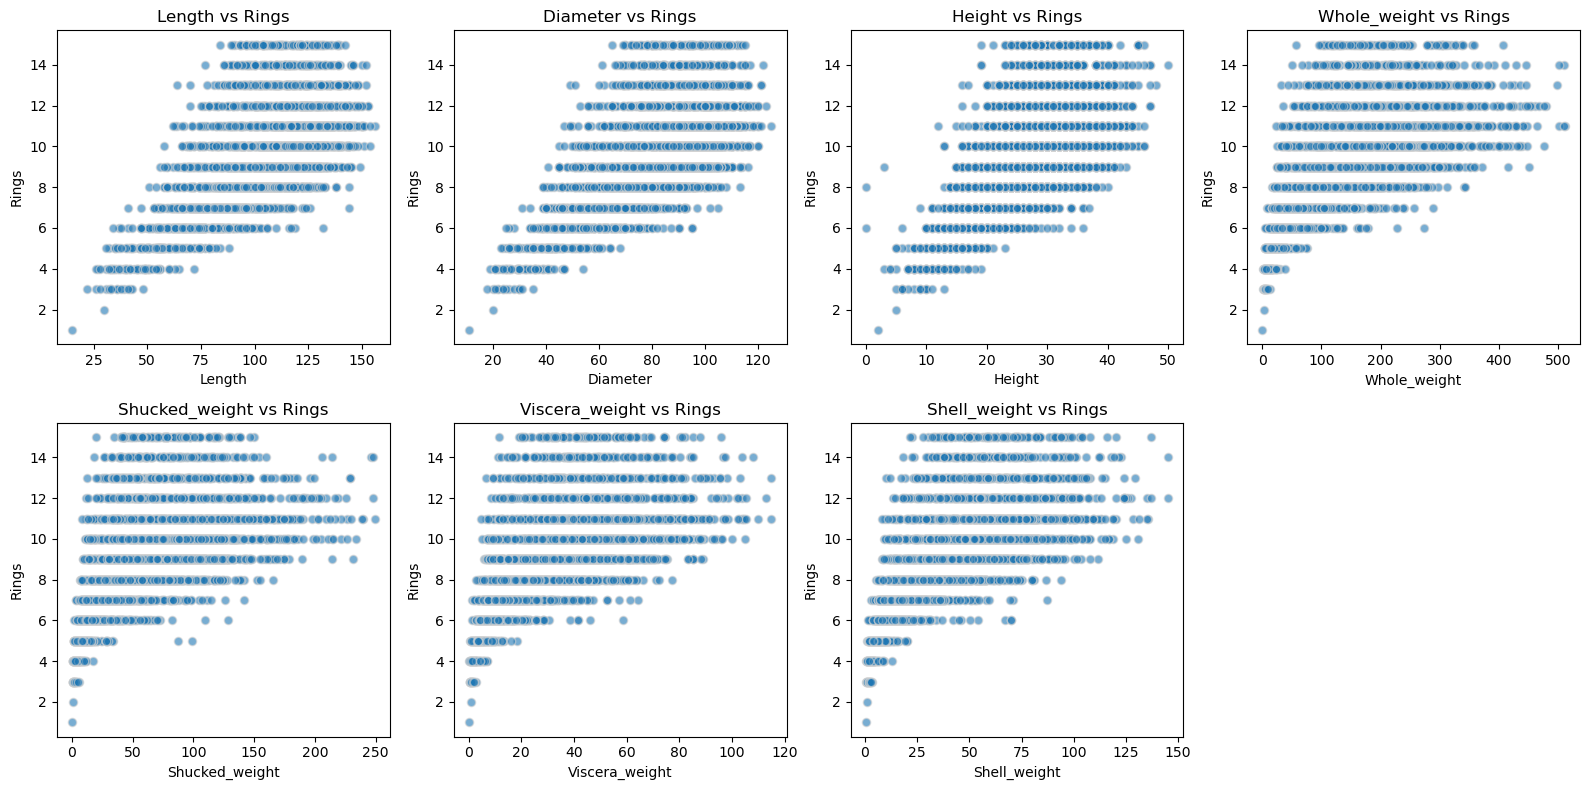

In [18]:
features= df.drop(columns=['Sex', 'Rings'], axis=0)
target = df['Rings']

fig, axs = plt.subplots(2,4, figsize=(16, 8))
axs = axs.flatten()

for i, feature in enumerate(features.columns):
    axs[i].scatter(features[feature], target, alpha = 0.6, edgecolor= 'lightgray')
    axs[i].set_title(f'{feature} vs Rings')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Rings')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()

### Modelo con dos features

Para continuar con el análisis, hemos desarrollado un modelo de regresión lineal que sirve como nuestro benchmark para evaluar el rendimiento de otras técnicas y modelos en el futuro. Este modelo utiliza dos características, 'Length' y 'Whole_weight', y ha sido entrenado utilizando el método de regresión lineal (`LinearRegression()`).

Para medir la efectividad del modelo, se emplearon varias métricas de regresión:

- **R² (Coeficiente de Determinación)**: Esta métrica nos indica qué proporción de la variabilidad de la variable dependiente es explicada por las variables independientes en el modelo. Un valor más alto de R² sugiere que el modelo tiene un mejor ajuste a los datos.

- **RMSE (Root Mean Squared Error)**: El RMSE proporciona una medida del error en las predicciones del modelo, expresando la diferencia promedio entre los valores predichos y los valores reales. Un RMSE más bajo indica un mejor rendimiento del modelo.

Además, se utilizó **cross-validation** (validación cruzada) con 10 pliegues para evaluar la estabilidad y generalización del modelo. Esta técnica permite verificar cómo se desempeña el modelo en diferentes subconjuntos de los datos, asegurando que los resultados no sean simplemente un reflejo del conjunto de entrenamiento.

In [19]:
X = df[['Length', 'Whole_weight']]
y = df['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
linear_reg = LinearRegression().fit(X_train, y_train)

y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
score = cross_val_score(linear_reg, X, y, cv=10)
residue = y_test - y_test_pred


lr_perf_df = pd.DataFrame({'rmse_train': [rmse_train], 'rmse_test': [rmse_test], 'R2_train': [r2_train], 
                           'R2_test': [r2_test], 'cv_score_mean': [score.mean()], 'cv_score_std': [score.std()]})
lr_perf_df

,rmse_train,rmse_test,R2_train,R2_test,cv_score_mean,cv_score_std
0,1.858511,1.909877,0.390102,0.417473,0.309525,0.130048


### Conclusiones del Modelo de Regresión Lineal

- **RMSE**:
  - **Entrenamiento**: 1.858511
  - **Prueba**: 1.909877
  - Indica un error promedio de aproximadamente 1.9 unidades en las predicciones.

- **R²**:
  - **Entrenamiento**: 0.390102
  - **Prueba**: 0.417473
  - Aproximadamente el 39% y 42% de la variabilidad de la variable dependiente es explicada por el modelo en los conjuntos de entrenamiento y prueba, respectivamente.

- **Cross-Validation Score**:
  - **Promedio**: 0.309525
  - **Desviación Estándar**: 0.130048
  - Rendimiento moderado del modelo con una variabilidad razonable en diferentes particiones del conjunto de datos.


Para continuar con el análisis, se procedió a graficar las predicciones frente a los valores reales, así como la distribución de los residuos.

Text(0, 0.5, 'Prediction')

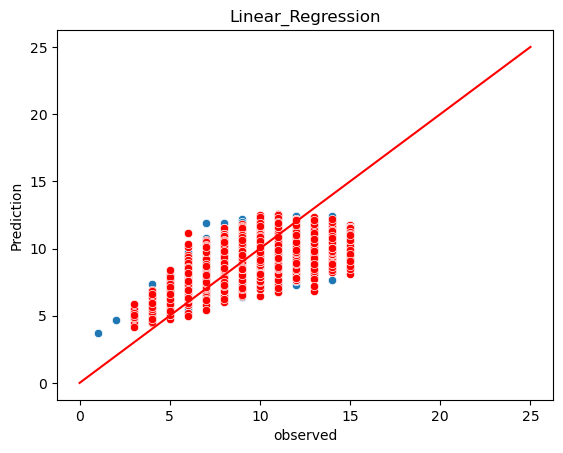

In [24]:
sns.scatterplot(x=y_test, y=y_test_pred) #Datos de testeo y la prediccion de los mismos
sns.scatterplot(x=y_train, y=y_train_pred, color='red') #Datos de entrenamiento y la prediccion de los mismos
plt.plot([0,25],[0,25], color='red')
plt.title('Linear_Regression')
plt.xlabel('observed')
plt.ylabel('Prediction')

### Resultado del Gráfico

- **Puntos en azul**: Representan las predicciones (`y_test_pred`) del conjunto de prueba, indicando cómo se predijeron los valores en este conjunto.
  
- **Puntos en rojo**: Muestran las predicciones (`y_train_pred`) del conjunto de entrenamiento. La superposición de ambos conjuntos permite observar el comportamiento del modelo en datos de prueba frente a los datos de entrenamiento.


Se puede notar una superposición entre las predicciones de testeo y de entrenamiento, lo que indica que el modelo está funcionando de manera consistente en ambos conjuntos de datos. Esta superposición sugiere que el modelo se ha ajustado bien a los datos de entrenamiento.

Además, se observa una tendencia creciente en los datos. A medida que los valores aumentan, también parece aumentar la dispersión de los puntos. Esto sugiere que, aunque las predicciones siguen la dirección del crecimiento, la variabilidad en las predicciones se incrementa con valores más altos.

Text(0.5, 1.0, 'Residue distribution')

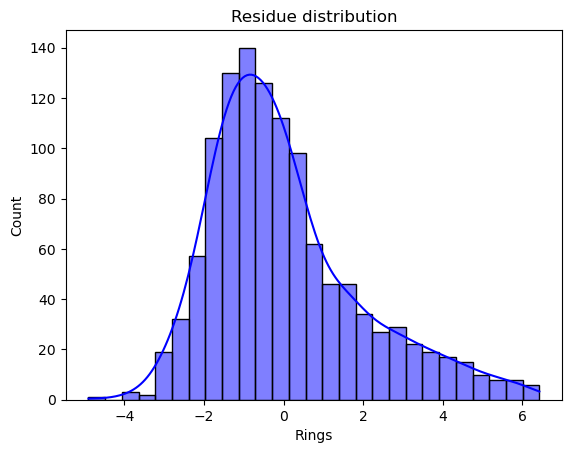

In [25]:
sns.histplot(x=residue, kde=True, color='blue')
plt.title('Residue distribution')

Se procedió a graficar los errores del modelo de regresión lineal, obteniendo una distribución que se asemeja a la normalidad. Este resultado es lógico y esperado, dado que uno de los supuestos fundamentales de la regresión lineal es que los residuos, o errores, deben distribuirse normalmente. Una distribución normal de los residuos sugiere que el modelo ha capturado adecuadamente la relación entre las variables, lo que indica un buen ajuste y una mayor confianza en las predicciones realizadas por el modelo.

### Modelo con mas features

A continuación, para obtener una comprensión más profunda de los datos y su comportamiento, se decidió evaluar un modelo de regresion lineal (`LinearRegression()`) que considera todas las características disponibles. Además, se espera que a mayor cantidad de **features** tomadas, mejore la capacidad predictiva y la robustez del análisis, proporcionando una visión más completa para el estudio.

In [29]:
X = df[['Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Height', 'Sex', 'Diameter', 'Length']]

X = pd.get_dummies(X, columns=['Sex'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=42)

feature_names = X.columns
feature_names

Index(['Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight',
       'Height', 'Diameter', 'Length', 'Sex_F', 'Sex_I', 'Sex_M'],
      dtype='object')

In [30]:
linear_reg = LinearRegression().fit(X_train, y_train)

lin_reg_train_pred = linear_reg.predict(X_train)
lin_reg_pred = linear_reg.predict(X_test)

rmse_train = root_mean_squared_error(y_train, lin_reg_train_pred)
r2_train = r2_score(y_train, lin_reg_train_pred)
rmse_test = root_mean_squared_error(y_test, lin_reg_pred)
r2_test = r2_score(y_test, lin_reg_pred)
score = cross_val_score(linear_reg, X,y, cv=10)

lr_perf_df = pd.DataFrame({'rmse_train': [rmse_train], 'rmse_test': [rmse_test], 'R2_train': [r2_train], 
                           'R2_test': [r2_test], 'cv_score_mean': [score.mean()], 'cv_score_std': [score.std()]})


lr_perf_df

,rmse_train,rmse_test,R2_train,R2_test,cv_score_mean,cv_score_std
0,1.6326,1.651903,0.538512,0.548537,0.462418,0.083308


### Conclusiones del Modelo de Regresión Lineal con mas features

- **RMSE**:
  - **Entrenamiento**: 1.6326
  - **Prueba**: 1.651903
  - Indica un error promedio de aproximadamente 1.64 unidades en las predicciones.

- **R²**:
  - **Entrenamiento**: 0.538512
  - **Prueba**: 0.548537
  - Aproximadamente el 54% de la variabilidad de la variable dependiente es explicada por el modelo en los conjuntos de entrenamiento y prueba, respectivamente.

- **Cross-Validation Score**:
  - **Promedio**: 0.462418
  - **Desviación Estándar**: 0.083308
  - Rendimiento moderado del modelo con una variabilidad razonable en diferentes particiones del conjunto de datos.


Se puede observar que, en comparación con el modelo anterior, ha habido un aumento significativo en el valor de R². Este incremento indica una mejora en la capacidad del modelo para captar la variabilidad presente en los datos.

Además, los resultados de la validación cruzada del segundo modelo muestran un promedio de puntuación de aproximadamente 0.462418, junto con una desviación estándar de 0.083308. Esto indica que, aunque el modelo tiene un rendimiento moderado, hay una variabilidad razonable en su desempeño a través de diferentes particiones del conjunto de datos.

Para seguir con el analisis, procedemos a imprimir los coeficientes de la regresion lineal

In [31]:
#defino los coeficientes
coefficients = linear_reg.coef_
intercept = linear_reg.intercept_

#hago un df
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
coef_df['Importance'] = coef_df['Coefficient'].abs()  # Valor absoluto para la importancia

print(coef_df)
print(f'Intercept: {intercept}')


          Feature  Coefficient  Importance
0    Whole_weight     0.020390    0.020390
1  Shucked_weight    -0.060189    0.060189
2  Viscera_weight    -0.017780    0.017780
3    Shell_weight     0.025470    0.025470
4          Height     0.077833    0.077833
5        Diameter     0.044802    0.044802
6          Length     0.008230    0.008230
7           Sex_F     0.208594    0.208594
8           Sex_I    -0.561939    0.561939
9           Sex_M     0.353345    0.353345
Intercept: 3.211668130138529


Cada coeficiente indica el cambio en la variable dependiente por cada unidad de cambio en la característica correspondiente.

- **Whole_weight (0.020390)**: Un aumento de 1 unidad en el peso total resulta en un incremento de aproximadamente 0.0204 en la variable dependiente.
- **Shucked_weight (-0.060189)**: Un incremento de 1 unidad en el peso pelado reduce la variable dependiente en aproximadamente 0.0602.
- **Viscera_weight (-0.017780)**: Un aumento de 1 unidad en el peso de las vísceras disminuye la variable dependiente en aproximadamente 0.0178.
- **Shell_weight (0.025470)**: Un aumento de 1 unidad en el peso de la concha incrementa la variable dependiente en aproximadamente 0.0255.
- **Height (0.077833)**: Un incremento de 1 unidad en la altura aumenta la variable dependiente en aproximadamente 0.0778.
- **Diameter (0.044802)**: Un aumento de 1 unidad en el diámetro incrementa la variable dependiente en aproximadamente 0.0448.
- **Length (0.008230)**: Un incremento de 1 unidad en la longitud resulta en un aumento de aproximadamente 0.0082 en la variable dependiente.

En cuanto a las variables categóricas de sexo:
- **Sex_F (0.208594)**: Representa un aumento de aproximadamente 0.2086 en la variable dependiente para el sexo femenino en comparación con la categoría de referencia.
- **Sex_I (-0.561939)**: Indica una disminución significativa de aproximadamente 0.5619 en la variable dependiente para el sexo intermedio.
- **Sex_M (0.353345)**: Refleja un aumento de aproximadamente 0.3533 en la variable dependiente para el sexo masculino.

El **intercepto (3.211668130138529)** representa el valor de la variable dependiente cuando todas las variables independientes son cero, sirviendo como punto de referencia para las predicciones del modelo.


### Linear Regression (Lasso)

El modelo de regresión lineal nos brinda una visión clara de cómo se relacionan las variables, pero puede haber problemas de sobreajuste, especialmente cuando trabajamos con conjuntos de datos que tienen muchas características. Para solucionar esto y lograr que el modelo sea más generalizable, podemos optar por **Lasso** (Least Absolute Shrinkage and Selection Operator). Esta técnica no solo ayuda a simplificar el modelo a través de la regularización, sino que también selecciona las características más importantes, descartando aquellas que no aportan mucho. Como resultado, podemos mejorar la capacidad predictiva del modelo y facilitar la interpretación de los resultados.

In [35]:
lr_lasso = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)

lrlasso_train_pred = lr_lasso.predict(X_train)
lrlasso_test_pred = lr_lasso.predict(X_test)

rmse_train = root_mean_squared_error(y_train, lrlasso_train_pred)
r2_train = r2_score(y_train, lrlasso_train_pred)
rmse_test = root_mean_squared_error(y_test, lrlasso_test_pred)
r2_test = r2_score(y_test, lrlasso_test_pred)
score = cross_val_score(lr_lasso, X,y, cv=10)

coeficients = lr_lasso.coef_


atributes_weight = pd.DataFrame({
    'Atribute': X.columns,
    'Weight': coeficients
})

features_selected = atributes_weight[atributes_weight['Weight'] != 0]

features_selected = features_selected.reindex(features_selected.Weight.abs().sort_values(ascending=False).index).reset_index(drop=True)

lrlasso_df = pd.DataFrame({'rmse_train': [rmse_train], 'rmse_test': [rmse_test], 'R2_train': [r2_train], 
                           'R2_test': [r2_test], 'cv_score_mean': [score.mean()], 'cv_score_std': [score.std()]})

print(lrlasso_df)
# print(coeficients)
print("")
print("Las caracteristicas seleccionadas junto a sus pesos fueron:")
print("")
features_selected

   rmse_train  rmse_test  R2_train   R2_test  cv_score_mean  cv_score_std
0    1.654506   1.657641  0.526044  0.545396       0.447721      0.084268

Las caracteristicas seleccionadas junto a sus pesos fueron:



,Atribute,Weight
0,Sex_I,-0.175141
1,Height,0.076554
2,Shucked_weight,-0.059089
3,Diameter,0.052549
4,Shell_weight,0.027090
5,Whole_weight,0.019029
6,Viscera_weight,-0.008620
7,Length,0.003626


El modelo de regresión Lasso se ha destacado en comparación con el modelo de regresión lineal simple (tanto con dos caracteristicas como con todas),  especialmente por su habilidad para manejar la complejidad de los datos y mitigar el riesgo de sobreajuste. Con un RMSE cercano a 1.65 en ambos conjuntos de entrenamiento y prueba, el modelo Lasso demuestra un rendimiento coherente, lo que sugiere que se está generalizando bien a nuevos datos. 

Además, el coeficiente de determinación R² muestra una mejora significativa en la capacidad del modelo para explicar la variabilidad de la variable dependiente, alcanzando alrededor de 0.53 y 0.55 para los conjuntos de entrenamiento y prueba, respectivamente. 

Un punto a destacar es la selección de características. Lasso ha logrado identificar atributos clave como "Sex_I" y "Height", lo que facilita una interpretación más sencilla y efectiva del modelo.


A continuación, en el trabajo se podria plantear un modelo más complejo como el **Stacking Regressor**. Esta técnica combina múltiples modelos de regresión, aprovechando sus fortalezas individuales para mejorar la capacidad predictiva general.